# Formula One Project: Modeling

DUE: December 4th, 2024 (Wed)  
Name(s): Sean O'Connor, Connor Coles    
Class: CSCI 349 - Intro to Data Mining  
Semester: Fall 2024  
Instructor: Brian King  

## Assignment Description

Copy over the important cells from the previous step that read in and cleaned your data to this new notebook file. You do not need to copy over all your EDA and plots describing your data, only the code that prepares your data for modeling. This notebook is about exploring the development of predictive models. Some initial preliminary work on applying some modeling techniques should be completed.
Be sure to commit and push all supporting code that you've completed in this file. Include in this notebook a summary cell at the top that details your accomplishments, challenges, and what you expect to accomplish for your final steps. Be sure to update your readme.md in your repository.

In [23]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import fastf1
import fastf1.plotting
from fastf1.ergast.structure import FastestLap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [4]:
# FastF1 general setup
cache_dir = '../data/cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

fastf1.Cache.enable_cache(cache_dir)
fastf1.plotting.setup_mpl(misc_mpl_mods=False, color_scheme=None)

In [30]:
# Define years and sessions of interest
years = [2021, 2022, 2023, 2024]
sessions = ['Race']  # Qualifying and Race sessions
# events = ['Brazil', 'Australia', 'Italy', 'United States'] 
events = ['Great Britain', 'Mexico', 'Brazil', 'Bahrain', 'United States'] 

In [31]:
# Data holders
weather_data_list = []
lap_data_list = []

# Loop through years and sessions
for year in years:
    for event_name in events:   
        for session_name in sessions:
            try:
                # Load the session
                session = fastf1.get_session(year, event_name, session_name)
                session.load()
                
                # Process weather data
                weather_data = session.weather_data
                weather_df = pd.DataFrame(weather_data)
                weather_df['Year'] = year
                weather_df['Session'] = session_name
                weather_data_list.append(weather_df)

                # Process lap data
                lap_data = session.laps
                lap_df = pd.DataFrame(lap_data)
                lap_df['Year'] = year
                lap_df['Event'] = event_name
                lap_df['Session'] = session_name
                lap_data_list.append(lap_df)
        
            except Exception as e:
                print(f"Error with {event_name} {session_name} ({year}): {e}")

# Combine weather and lap data into separate DataFrames
if weather_data_list:
    weather_data_combined = pd.concat(weather_data_list, ignore_index=True)
    print("Weather Data:")
    print(weather_data_combined.head())

if lap_data_list:
    lap_data_combined = pd.concat(lap_data_list, ignore_index=True)
    print("Lap Data:")
    print(lap_data_combined.head())

core           INFO 	Loading data for British Grand Prix - Race [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data f

Error with Great Britain Race (2022): Failed to load any schedule data.


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


Error with Mexico Race (2022): Failed to load any schedule data.


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


Error with Brazil Race (2022): Failed to load any schedule data.


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


Error with Bahrain Race (2022): Failed to load any schedule data.


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


Error with United States Race (2022): Failed to load any schedule data.


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


Error with Great Britain Race (2023): Failed to load any schedule data.


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


Error with Mexico Race (2023): Failed to load any schedule data.


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


Error with Brazil Race (2023): Failed to load any schedule data.


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


Error with Bahrain Race (2023): Failed to load any schedule data.


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


Error with United States Race (2023): Failed to load any schedule data.


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


Error with Great Britain Race (2024): Failed to load any schedule data.


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


Error with Mexico Race (2024): Failed to load any schedule data.


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


Error with Brazil Race (2024): Failed to load any schedule data.


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


Error with Bahrain Race (2024): Failed to load any schedule data.


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


Error with United States Race (2024): Failed to load any schedule data.
Weather Data:
                    Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0 0 days 00:00:44.848000     28.4      41.3    1007.7     False       51.1   
1 0 days 00:01:44.867000     28.5      41.0    1007.8     False       51.1   
2 0 days 00:02:44.883000     28.5      41.2    1007.7     False       51.3   
3 0 days 00:03:44.881000     28.6      39.7    1007.7     False       51.3   
4 0 days 00:04:44.882000     28.6      39.8    1007.8     False       51.8   

   WindDirection  WindSpeed  Year Session  
0            155        0.3  2021    Race  
1            220        0.1  2021    Race  
2            339        0.1  2021    Race  
3             22        0.3  2021    Race  
4            180        0.1  2021    Race  
Lap Data:
                    Time Driver DriverNumber LapTime  LapNumber  Stint  \
0 0 days 01:04:25.585000    VER           33     NaT        1.0    1.0   
1 0 days 01:04:28.48400

In [32]:
# Convert lap times to seconds for easier modeling
def convert_timedelta_to_seconds(td):
    if pd.isna(td):
        return None
    return td.total_seconds()

# Process lap times
lap_data_combined['LapTime_seconds'] = lap_data_combined['LapTime'].apply(convert_timedelta_to_seconds)
lap_data_combined['Sector1Time_seconds'] = lap_data_combined['Sector1Time'].apply(convert_timedelta_to_seconds)
lap_data_combined['Sector2Time_seconds'] = lap_data_combined['Sector2Time'].apply(convert_timedelta_to_seconds)
lap_data_combined['Sector3Time_seconds'] = lap_data_combined['Sector3Time'].apply(convert_timedelta_to_seconds)

In [33]:
# Merge weather data with lap data
# Convert timedelta to datetime for merging
def convert_time_for_merge(df, base_date='2024-01-01'):
    if 'Time' in df.columns:
        # Create a base datetime and add the timedelta
        base = pd.Timestamp(base_date)
        if df['Time'].dtype == 'timedelta64[ns]':
            df['Time'] = base + df['Time']
    return df

# Process both dataframes
weather_data_combined = convert_time_for_merge(weather_data_combined)
lap_data_combined = convert_time_for_merge(lap_data_combined)

# Now merge based on nearest timestamp
merged_data = pd.merge_asof(
    lap_data_combined.sort_values('Time'),
    weather_data_combined.sort_values('Time'),
    on='Time',
    suffixes=('_lap', '_weather')
)

print(merged_data.head())

                     Time Driver DriverNumber                LapTime  \
0 2024-01-01 00:39:08.419    MAZ            9                    NaT   
1 2024-01-01 00:39:08.419    VER           33 0 days 00:01:58.245000   
2 2024-01-01 00:39:09.712    HAM           44 0 days 00:01:59.538000   
3 2024-01-01 00:39:12.872    LEC           16 0 days 00:02:02.698000   
4 2024-01-01 00:39:13.946    BOT           77 0 days 00:02:03.772000   

   LapNumber  Stint PitOutTime PitInTime Sector1Time            Sector2Time  \
0        1.0    1.0        NaT       NaT         NaT                    NaT   
1        1.0    1.0        NaT       NaT         NaT 0 days 00:00:53.703000   
2        1.0    1.0        NaT       NaT         NaT 0 days 00:00:54.367000   
3        1.0    1.0        NaT       NaT         NaT 0 days 00:00:55.232000   
4        1.0    1.0        NaT       NaT         NaT 0 days 00:00:56.397000   

   ... Sector3Time_seconds AirTemp Humidity Pressure  Rainfall  TrackTemp  \
0  ...         

In [46]:
# Select features for modeling
feature_columns = [
    'TrackTemp', 'AirTemp', 'Humidity', 'Pressure', 'WindSpeed',
    'TyreLife', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST'
]

target_column = 'LapTime_seconds'

# Print available columns
print(merged_data.columns)

# Remove rows with missing values
model_data = merged_data[feature_columns + [target_column]].dropna()

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'Year_lap', 'Event', 'Session_lap',
       'LapTime_seconds', 'Sector1Time_seconds', 'Sector2Time_seconds',
       'Sector3Time_seconds', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall',
       'TrackTemp', 'WindDirection', 'WindSpeed', 'Year_weather',
       'Session_weather'],
      dtype='object')


In [35]:
# Split the data into training and testing sets
X = model_data[feature_columns]
y = model_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [36]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
# Train and evaluate multiple models

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regressor': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

In [43]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    print(f"{name} model trained.")
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    print(f"Predictions made with {name} model.")
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"Metrics calculated with {name} model.")
    
    results[name] = {
        'RMSE': rmse,
        'R2': r2
    }

Linear Regression model trained.
Predictions made with Linear Regression model.
Metrics calculated with Linear Regression model.
Random Forest model trained.
Predictions made with Random Forest model.
Metrics calculated with Random Forest model.
Decision Tree model trained.
Predictions made with Decision Tree model.
Metrics calculated with Decision Tree model.
Gradient Boosting model trained.
Predictions made with Gradient Boosting model.
Metrics calculated with Gradient Boosting model.
Support Vector Regressor model trained.
Predictions made with Support Vector Regressor model.
Metrics calculated with Support Vector Regressor model.
XGBoost model trained.
Predictions made with XGBoost model.
Metrics calculated with XGBoost model.



Model Performance:

Linear Regression:
RMSE: 7.33 seconds
R2 Score: 0.709

Random Forest:
RMSE: 2.48 seconds
R2 Score: 0.967

Decision Tree:
RMSE: 3.42 seconds
R2 Score: 0.937

Gradient Boosting:
RMSE: 2.93 seconds
R2 Score: 0.953

Support Vector Regressor:
RMSE: 7.51 seconds
R2 Score: 0.694

XGBoost:
RMSE: 2.79 seconds
R2 Score: 0.958


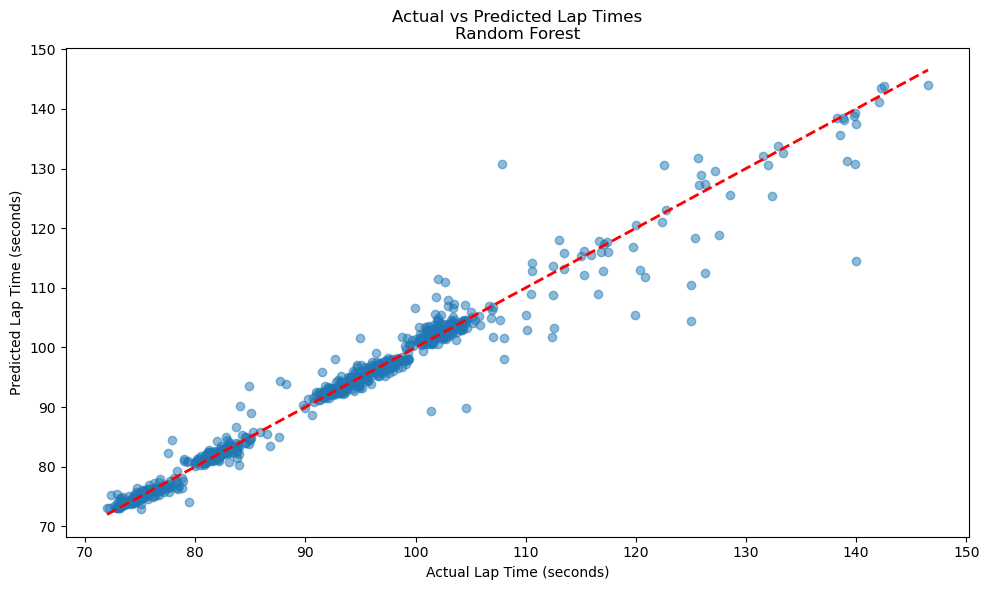

In [44]:
# Print results
print("\nModel Performance:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"RMSE: {metrics['RMSE']:.2f} seconds")
    print(f"R2 Score: {metrics['R2']:.3f}")

# Visualize predictions vs actual values for the best model
plt.figure(figsize=(10, 6))
best_model_name = max(results.items(), key=lambda x: x[1]['R2'])[0]
best_model = models[best_model_name]
y_pred = best_model.predict(X_test_scaled)

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (seconds)')
plt.ylabel('Predicted Lap Time (seconds)')
plt.title(f'Actual vs Predicted Lap Times\n{best_model_name}')
plt.tight_layout()
plt.show()

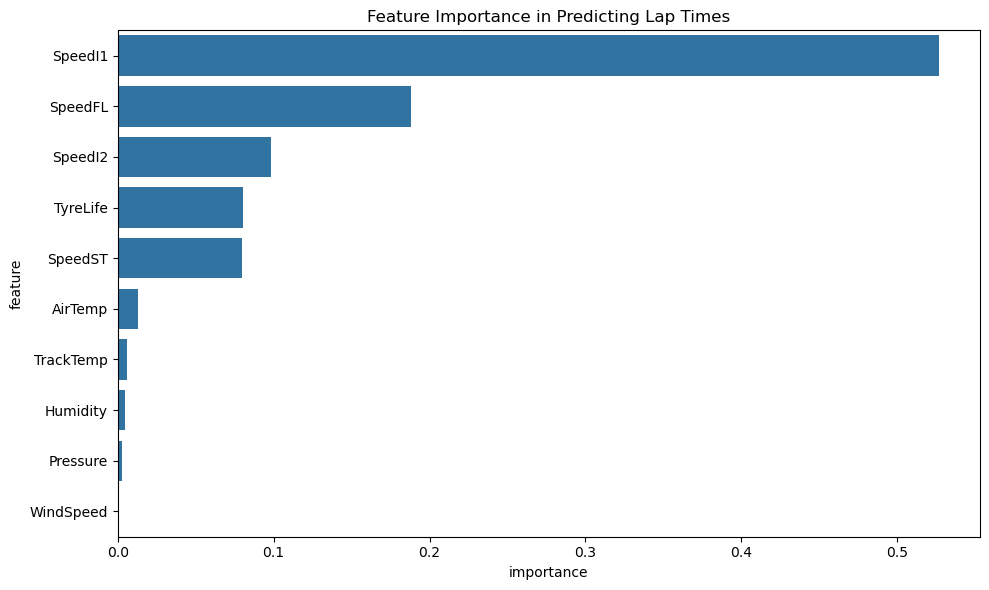

In [45]:
# Feature importance for Random Forest
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance in Predicting Lap Times')
    plt.tight_layout()
    plt.show()